Case Study - MNIST data for Hand Written digits classification

In [1]:
#loading the mnist data
from tensorflow.keras.datasets.mnist import load_data

(x_train,y_train),(x_test,y_test)=load_data()

print("train",x_train.shape)
print("test",x_test.shape)

train (60000, 28, 28)
test (10000, 28, 28)


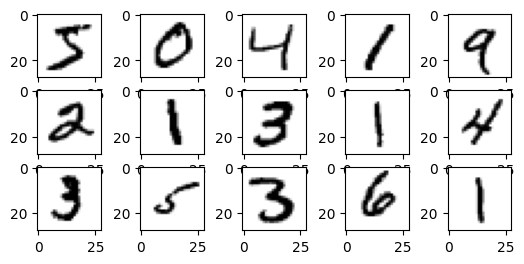

In [2]:
from matplotlib import pyplot
for i in range(15):
  pyplot.subplot(5,5,1+i)
  pyplot.imshow(x_train[i],cmap='gray_r')
pyplot.show()

In [3]:
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display

In [4]:
(train_images,train_labels),(_,_)=tf.keras.datasets.mnist.load_data()

In [5]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images=(train_images-127.5)/127.5 #Normalize the image to [-1, +1]

In [6]:
BATCH_SIZE=256
buffer_size=60000 #same as train data

In [7]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(BATCH_SIZE)

In [8]:
def make_generator_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape==(None, 7,7,256) #None is the batch size
  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
  assert model.output_shape==(None, 7,7,128) #None is the batch size
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  #upsampling to 14x14
  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape==(None, 14,14,64) #None is the batch size
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  #upsampling to 28x28
  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
  assert model.output_shape==(None, 28,28,1) #None is the batch size

  return model

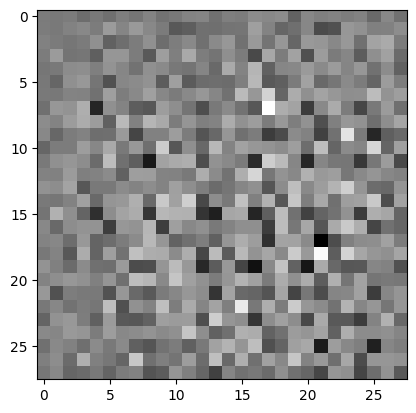

In [9]:
#visualizing the output generated
generator=make_generator_model()

noise=tf.random.normal([1,100])
generated_image=generator(noise,training=False)

plt.imshow(generated_image[0,:,:,0], cmap='gray_r')

In [10]:
def make_discriminator_model():
  model=tf.keras.Sequential()

  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1,activation='sigmoid'))

  return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50046504]], shape=(1, 1), dtype=float32)


In [12]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

In [14]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
EPOCHS=
noise_dim=100
num_examples_to_generate=16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

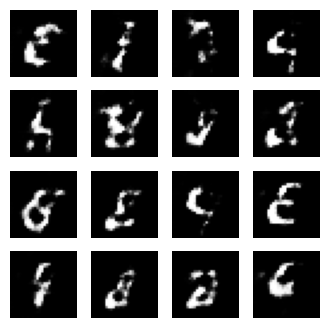

In [21]:
train(train_dataset, EPOCHS)

In [22]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [23]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

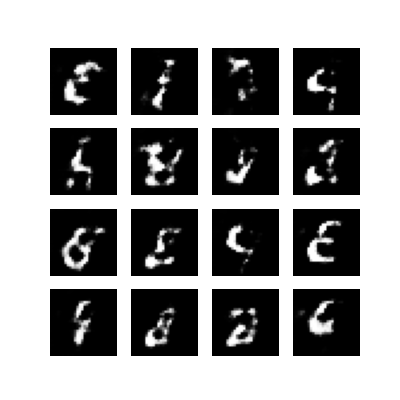

In [24]:
display_image(EPOCHS)